In [148]:
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import matplotlib.pyplot as plt

In [114]:
# Read the raw data
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [115]:
len(words)

32033

In [116]:
# Build the vocab
chars = sorted(set(list(''.join(words))))

ctoi = {c: i + 1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i: c for c, i in ctoi.items()}
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [232]:
# Build the dataset
context_length = 3 # consider three words to predict the next word
X, y = [],[]
for word in words:
    # print('WORD', word)
    context = [0] * context_length
    for char in word + '.':
        id = ctoi[char]
        X.append(context)
        y.append(id)

        # print(''.join(itoc[i] for i in context), '-->', itoc[id])
        context = context[1:] + [id]

X = torch.tensor(X)
y = torch.tensor(y)

In [233]:
X.shape, y.shape, X.dtype, y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [268]:
# Initialize parameters

g = torch.Generator().manual_seed(2147483647)

# Lookup table for character embedding
emb_dim = 10
C = torch.randn((27, emb_dim), generator = g)

hidden_layer_size = 300
W1 = torch.randn(3 * emb_dim, hidden_layer_size, generator = g)
b1 = torch.randn(hidden_layer_size, generator = g)
W2 = torch.randn(hidden_layer_size, 27, generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [269]:
# Indexing all the chars in a given input
# C[[5, 6, 7]]
embs = C[X]
embs.shape

# embs.storage() -> Stores the tensor values in a sequential manner
# When view is applied, it just modifies some attributes of the embs (like storage offset, etc) so that it is represented as we like
# So there is no new memory created for this operation
# embs = embs.view(-1, 6)

torch.Size([228146, 3, 10])

In [270]:
# Softmax + Cross entropy losss
# This is very inefficient as it creates copies of tensors and mathematically unstable for large numbers
# counts = logits.exp()
# probs = counts/counts.sum(1, keepdims = True)
# loss = -probs[torch.arange(32), y].log().mean()

# loss = F.cross_entropy(logits, y) is Stable

In [271]:
for p in parameters:
    p.requires_grad = True

In [245]:
# Learning rate experimentation
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [246]:
batch_size = 32

lri = []
lossi = []
for i in range(1000):

    # Get the minibatch
    ids = torch.randint(0, X.shape[0], (batch_size, ))

    embs = C[X[ids]] # [32, 3, 2]
    embs = embs.view(-1, 6)

    # Fwd pass
    h = torch.tanh(embs @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, y[ids])

    # Zero grad for backward pass
    for p in parameters:
        p.grad = None

    # Compute grad
    loss.backward()

    # Gradient descent - optimization step
    # Update the parameters
    lr = lrs[i]
    # lr = 0.1
    # lr = 0.001 # lr decay for the last few steps
    for p in parameters:
        p.data += -lr * p.grad

    # Track lr vs loss
    lri.append(lre[i])
    lossi.append(loss.item())
        
print('loss -->', loss.item())

loss --> 6.921151161193848


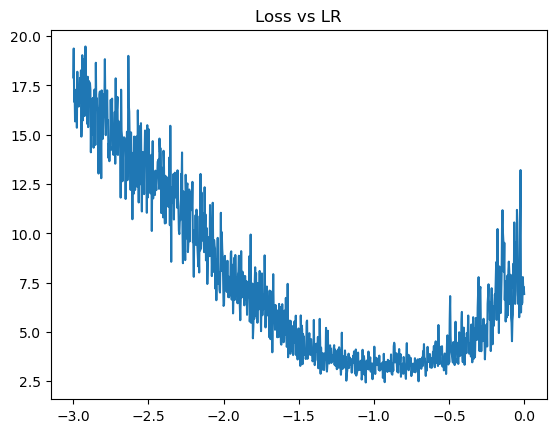

In [247]:
# plt.plot(lri, lossi)
# plt.title('Loss vs LR')
# plt.show()

# # LR (exponent) near -1 is a good value i.e learning rate of 10**-1 -> 0.1

In [199]:
# Model with very less training loss doesn't necessarily mean a good model
# larger models could overfit -> work really well on the train data but perform bad on the test
# So we need to have the train,val and test split to check this behaviour with different variations of the network

In [253]:
# Build the dataset (train, val and test)
def build_dataset(words):
    context_length = 3 # consider three words to predict the next word
    X, y = [],[]
    for word in words:
        # print('WORD', word)
        context = [0] * context_length
        for char in word + '.':
            id = ctoi[char]
            X.append(context)
            y.append(id)
    
            # print(''.join(itoc[i] for i in context), '-->', itoc[id])
            context = context[1:] + [id]
    
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

random.seed(42)
random.shuffle(words)
idx1 = int(0.8 * len(words))
idx2 = int(0.9 * len(words))

Xtrain, ytrain = build_dataset(words[:idx1])
Xval, yval = build_dataset(words[idx1:idx2])
Xtest, ytest = build_dataset(words[idx2:])

In [283]:
def fwd_pass(Xtemp, ytemp):
    # Get the minibatch
    ids = torch.randint(0, Xtemp.shape[0], (batch_size, ))

    embs = C[Xtemp[ids]] # [32, 3, 2]
    embs = embs.view(-1, 30)
    
    h = torch.tanh(embs @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, ytemp[ids])
    return loss
    
def train():
    batch_size = 32
    losses_train = []
    losses_val = []
    for i in range(30000):
    
        # Fwd pass
        loss_train = fwd_pass(Xtrain, ytrain)
        loss_val = fwd_pass(Xval, yval)
    
        # Zero grad for backward pass
        for p in parameters:
            p.grad = None
    
        # Compute grad
        loss_train.backward()
    
        # Gradient descent - optimization step
        # Update the parameters
        # lr = lrs[i]
        # lr = 0.1
        lr = 0.001 # lr decay for the last few steps
        for p in parameters:
            p.data += -lr * p.grad
    
        # Track lr vs loss
        losses_train.append(loss_train.item())
        losses_val.append(loss_val.item())
    
    print('Loss train -->', losses_train[-1])
    print('Loss val -->', losses_val[-1])

In [ ]:
train()

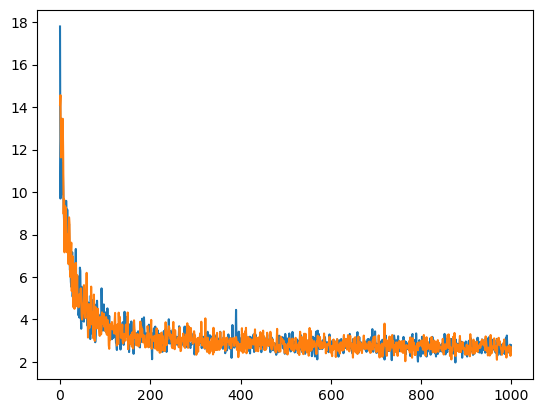

In [257]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.show()
# Both the train and val losses are equal (not overfitting) and relatively high (underfitting)
# Need to increase the complexity of the model

In [285]:
train()

Loss train --> 2.407904863357544
Loss val --> 1.925126075744629


In [289]:
# Inference
g = torch.Generator().manual_seed(2147483647 * 10)

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [idx]
        out.append(idx)

        # If we predict '.' then break
        # i.e it's the end of the sequence
        if idx == 0:
            break
    print(''.join(itoc[i] for i in out))

aerestah.
eldsa.
benley.
aza.
llia.
juric.
lie.
lamarr.
rabelridtayla.
karicis.
dhirianneen.
setah.
ber.
jun.
dabelsen.
macarhton.
tas.
sera.
odei.
wace.


In [290]:
# Notes
# Choosing learning rate:
# 1. Choose a diverse set of values and find a good range
# 2. In this smaller range, explore the values.
# 3. Use a linear/log scale decay for the learning rate in the training process

# Overfitting/Underfitting - Use train and val splits to test different variants of the network